In [1]:
import copy
import numpy as np
import sys

In [2]:
import analysis_config

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [5]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations

In [6]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

# Load Data

In [7]:
default_sim = 'm12i'
default_snum = 465

In [8]:
if len( sys.argv ) == 2:
    sim_name = sys.argv[1]
else:
    sim_name = default_sim

In [9]:
# Automatically set or retrieve args
if len( sys.argv ) == 3:
    try:
        snum = int( sys.argv[2] )
    except ValueError:
        snum = default_snum
else:
    snum = default_snum

In [10]:
galdef = '_galdefv3'

In [11]:
file_manager = file_management.FileManager( 'CGM_origin' )

In [12]:
defaults = file_manager.get_linefinder_analysis_defaults(
    '_CGM_snum{}'.format( snum ),
    sim_name = sim_name,
    galdef = galdef
)

In [14]:
ind = defaults['ahf_index'] - snum

In [15]:
w = a_worldlines.Worldlines( **defaults )

In [16]:
w.retrieve_halo_data()

In [17]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print plot_label

$M_{\rm h} = 10^{12} M_\odot$, z=0.25


In [18]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_ORIGIN )

In [19]:
classification_list.remove( 'is_CGM_satellite_ISM' )

In [20]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

In [21]:
g_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_GAS,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
)

In [22]:
g_plotter = generic_plotter.GenericPlotter(
    g_data,
    label=plot_label,
)

In [23]:
s_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],    
)

In [24]:
s_plotter = generic_plotter.GenericPlotter( s_data )

In [25]:
ahf_data = analyze_ahf.HaloData( file_manager.get_halo_dir( sim_name ), tag='smooth', index=defaults['ahf_index'] )

In [26]:
ahf_plotter = plot_ahf.HaloPlotter( ahf_data )

### Create a circle to plot

In [27]:
length_scale = w.halo_data.get_mt_data(
    w.galids.parameters['mt_length_scale'],
    snums = snum,
    return_values_only = False,
    a_power = 1.
) / w.ptracks.data_attrs['hubble']
r_gal = length_scale * w.galids.parameters['galaxy_cut']

In [28]:
circle = []
for phi in np.linspace( 0., 2.*np.pi, 256 ):
    
    circle.append(
        [ r_gal*np.cos(phi), r_gal*np.sin(phi), 0. ]
    )
    
circle = np.array( circle )

rotated_circle = data_operations.align_axes( circle, s_data.total_ang_momentum, )

# Illustrative Plot

In [29]:
r_vir = w.r_vir.values[ind]

In [30]:
t_show_min = {
    465 : 0.5,
    172 : 0.25,
    214 : 0.25,
}
t_show_max = {
    465 : 1.0,
    172 : 0.5,
    214 : 0.5,
}

In [31]:
data_args = {
    465 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    172 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    214 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
}

is_CGM_NEP


/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/scipy-0.19.0-py2.7-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


is_outside_any_gal_IP
is_outside_any_gal_EP


/opt/apps/intel17/python/2.7.13/lib/python2.7/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


is_CGM_NEP
is_outside_any_gal_IP
is_outside_any_gal_EP
File saved at /home1/03057/zhafen/papers/CGM_origin/figures/streamlines_m12i_CGM_snum465_galdefv3.png


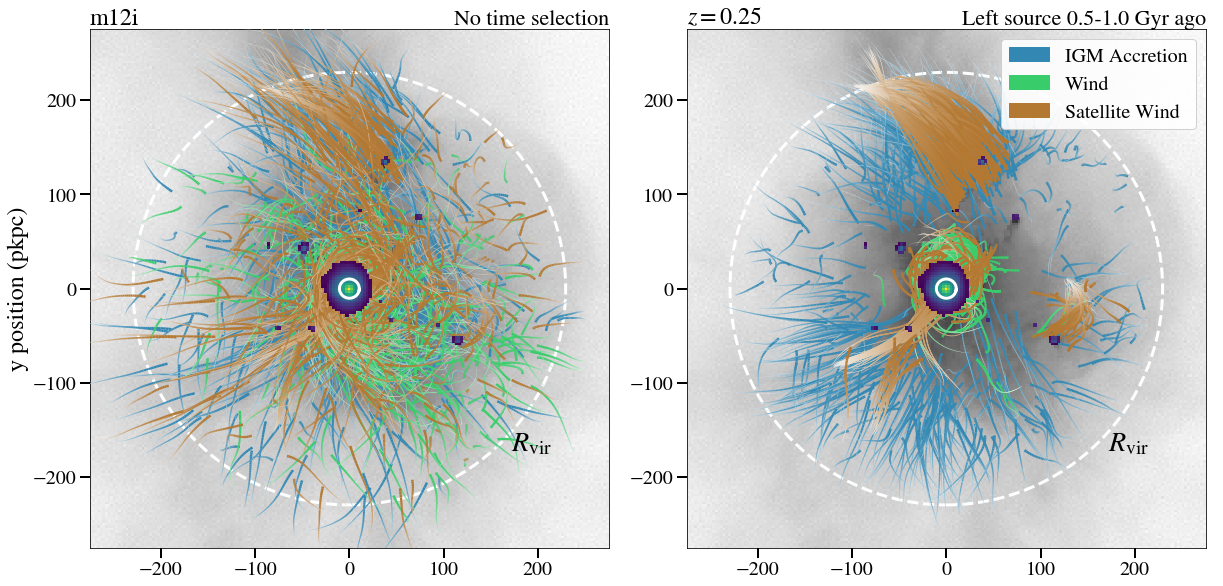

In [32]:
fig = plt.figure( figsize=(20,10), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 1, 2 )
axs = [ plt.subplot( gs[0,0] ), plt.subplot( gs[0,1] ) ]

gs.update( wspace=0.15 )

plotted_range = [ -1.2*r_vir, 1.2*r_vir ]

for j, sample_selected_interval in enumerate( [ False, True ] ):
    
    ax = axs[j]
    
    labels = []
    color_objects = []
    for i, classification in enumerate( [ 'is_CGM_NEP', 'is_outside_any_gal_IP', 'is_outside_any_gal_EP', ] ):

        w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
        
        # Don't plot CGM EP for m10s at low-z when applying the time cut, because there are just
        # too few particles
        if (
            classification == 'is_outside_any_gal_EP' and
            ax.is_last_col() and
            config.MASS_BINS[sim_name] == 'm10' and
            snum == 465
        ):
            continue
        
        print( classification )
        w_plotter.plot_streamlines(
            ax = ax,
            classification = classification,
            classification_ind = ind,
            start_ind = ind,
            sample_size = 500,
            sample_selected_interval = sample_selected_interval,
            t_show_min = t_show_min[snum],
            t_show_max = t_show_max[snum],
            x_data_kwargs = data_args[snum],
            y_data_kwargs = data_args[snum],
            linewidth = 2.5,
            plot_halos = False,
            plot_xlabel = ( sim_name == 'm10y' ),
            plot_ylabel = ax.is_first_col(),
            x_range = plotted_range,
            y_range = plotted_range,
            fontsize = 24,
        )

        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
            ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )                                                                    
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

    if j==0:
        plot_label = sim_name
    else:
        plot_label = r'$z = {:.2g}$'.format( g_data.redshift )
    vmaxes = {
        'm10' : 4e3,
        'm11' : 4e3,
        'm12' : 4e3,
    }
    vmax = vmaxes[config.MASS_BINS[sim_name]]
    g_plotter.histogram2d(
        'Rx',
        'Ry',
        cmap = cm.Greys,
        ax = ax,
        x_range = plotted_range,
        y_range = plotted_range,
        n_bins = 200,
#         vmin = 1,
        vmax = vmax,
        add_colorbar = False,
        add_x_label = False,
        add_y_label = False,
        label_fontsize = 24,
        plot_label = plot_label,
    )
    
    vmins = {
        172 : {
            'm10' : 10,
            'm11' : 10,
            'm12' : 20,
        },
        214 : {
            'm12' : 50,
        },
        465 : {
            'm10' : 20,
            'm11' : 20,
            'm12' : 5e2,
        },
    }
    vmin = vmins[snum][config.MASS_BINS[sim_name]]
    s_plotter.histogram2d(
        'Rx',
        'Ry',
        cmap = cm.viridis,
        ax = ax,
        x_range = plotted_range,
        y_range = plotted_range,
        n_bins = 200,
        vmin = vmin,
#         vmax = 4e3,
        plot_label = None,
        add_colorbar = False,
        add_x_label = False,
        add_y_label = False,
        label_fontsize = 20,
        zorder = 150,
        min_bin_value_displayed = vmin,
    )

    # Virial Radius circle
    cir = mpatches.Circle(
        [0, 0],
        radius = r_vir,
        linewidth = 3,
        color = 'w',
        linestyle = '--',
        fill = False,
        facecolor = 'w',
    )
    ax.add_patch( cir )
    ax.annotate(
        s = r'$R_{\rm vir}$',
        xy = ( .7475*r_vir, -.7475*r_vir ),
        xycoords = 'data',
        fontsize = 28,
        color = 'k',
        zorder = 150,
    )
    
    # Galaxy disk circle
    ax.plot(
        rotated_circle[:,0],
        rotated_circle[:,1],
        color = 'w',
        linewidth = 3,
        zorder = 200,
    )
    
    if ax.is_first_col():
        filter_label = 'No time selection'
    if ax.is_last_col():
        filter_label = 'Left source {}-{} Gyr ago'.format(
            t_show_min[snum],
            t_show_max[snum],
        )
    ax.annotate(
        s = filter_label,
        xy = ( 1., 1. ),
        xycoords = 'axes fraction',
        va = 'bottom',
        ha = 'right',
        fontsize = 22,
    )

    if ax.is_last_col():
        leg = ax.legend(
            color_objects,
            labels,
            prop={'size': 20},
            ncol=1,
    #         loc=(0.65, 0.83),
            loc='upper right',
            fontsize=24,
            framealpha = 0.9,
        )
        leg.set_zorder( 200 )

    ax.set_aspect( 'equal' )

save_file = 'streamlines_{}.png'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
    resolution = 50,
)


### Plot vs Time

In [33]:
w.data_masker.clear_masks()

In [34]:
y_max = np.nanpercentile( w.get_selected_data_over_time(
    data_key = 'R',
    snum = 465,
    classification = 'is_CGM_NEP',
)[:ind], 99. )*1.1

/home1/03057/zhafen/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


File saved at /home1/03057/zhafen/papers/CGM_origin/figures/r_vs_time_m12i_CGM_snum465_galdefv3.pdf


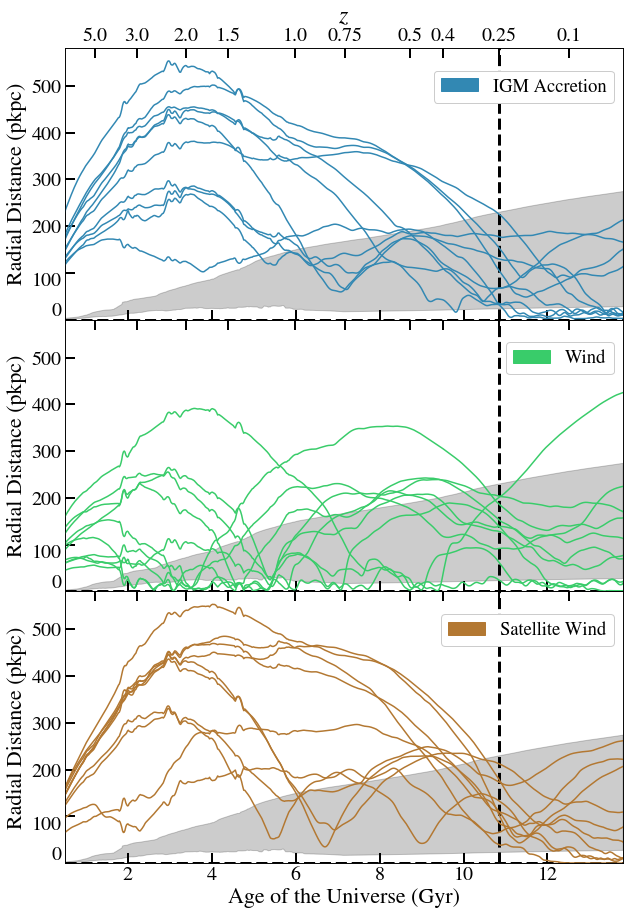

In [35]:
fig = plt.figure( figsize=(10,15), facecolor='white' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 3, 1 )

y_maxes = []
for i, classification in enumerate( classification_list ):
    
    ax = plt.subplot(gs[i,0])
    
#     if ax.is_first_row():
#         ax.annotate(
#             s = m_plot_label,
#             xy = (0,1.1),
#             xycoords = 'axes fraction',
#             va = 'bottom',
#             fontsize = 24,
#         )
    if classification == 'is_CGM_IP':
        ax.annotate(
            s = m_plot_label,
            xy = (0.05,0.95),
            xycoords = 'axes fraction',
            va = 'top',
            fontsize = 24,
        )
    
    gs.update(wspace=0.025, hspace=0.0001)
    
    w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )
    
    class_y_max = w_plotter.plot_streamlines_vs_time(
        y_key = 'R',
        classification = classification,
        classification_ind = ind,
        start_ind = 0,
        end_ind = 595,
        sample_size = 10,
        y_data_kwargs = { 'smooth_data' : True },
        ax = ax,
        x_range = [0.5, 13.8 ],
        y_range = [0., 550, ],
        horizontal_line_value = 0.,
        plot_CGM_region = True,
        return_y_max = True,
    )
    y_maxes.append( class_y_max )
        
    # Make virtual artists to allow a legend to appear
    labels = []
    color_objects = []
    color_object = matplotlib.patches.Rectangle(                         
        (0, 0),                                                          
        1,                                                               
        1,                                                               
        fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        alpha = p_constants.CLASSIFICATION_ALPHA,                        
    )                                                                    
    color_objects.append( color_object )                                 
    labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
    
    # Plot the outer edge of the galaxy under galdefv2
#     ax.plot( w.get_data( 'time')[:r_gal.size], w.r_gal, color='k', linewidth=3.5 )

    # Legend
    l = ax.legend(
        color_objects,
        labels,
        prop={'size': 18.5},
        ncol=1,
        bbox_to_anchor=(1, 0.95),
        loc='upper right',
        fontsize=20,
        framealpha=1.,
    )
    l.set_zorder( 200. )
        
# Changes to axes
for i, classification in enumerate( classification_list ):
    
    ax = plt.subplot(gs[i,0])
    ax.set_ylim( 0, 1.05*max( y_maxes ) )
    
    # Add redshift to the axis
    ax2 = plotting.add_redshift_to_axis(
        ax,
        hubble = w.ptracks.data_attrs['hubble'],
        omega_matter = w.ptracks.data_attrs['omega_matter'],
        tick_redshifts = np.array([ 0.1, 0.25, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 5, ])
    )
    
    # Change tick orientation
    ax.tick_params( direction='in' )
    ax2.tick_params( direction='in' )
    
    # Hide overlapping labels
    if not ax.is_first_row():
        ax2.xaxis.set_ticklabels([])
    if not ax.is_last_col():
        ax.xaxis.set_ticklabels([])
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[1].set_verticalalignment( 'top' )
    
    # X label
    if ax2.is_first_row():
        ax2.set_xlabel( r'$z$', fontsize=24 )
        
save_file = 'r_vs_time_{}.pdf'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)


#### Temperature

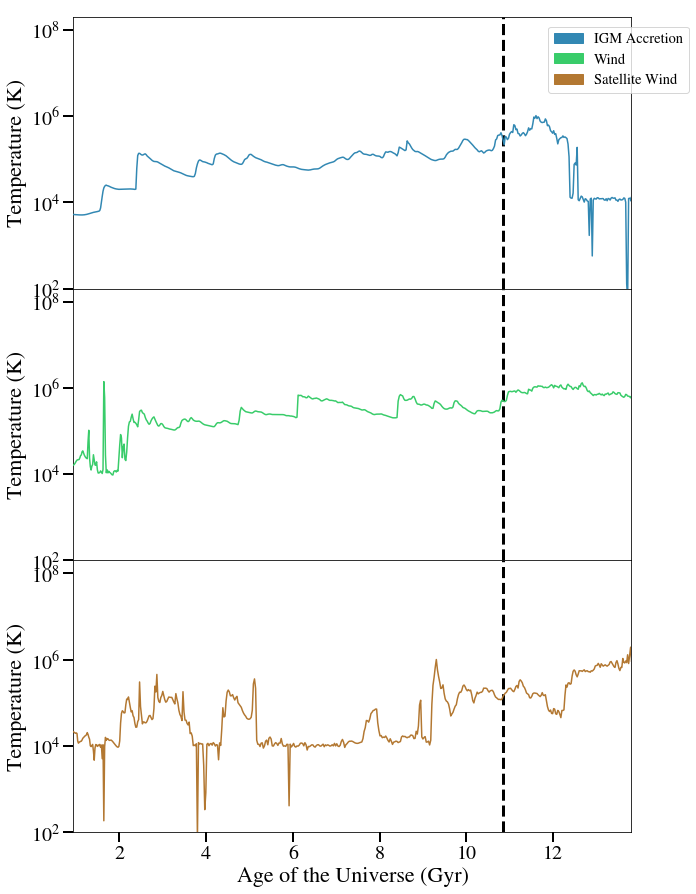

In [36]:
fig = plt.figure( figsize=(10,15), facecolor='white' )
ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 3, 1 )

labels = []
color_objects = []
for i, classification in enumerate( classification_list ):
    
    ax = plt.subplot(gs[i,0])
    
    gs.update(wspace=0.025, hspace=0.0001)
    
    w_plotter.plot_streamlines_vs_time(
        y_key = 'T',
        classification = classification,
        classification_ind = ind,
        start_ind = 0,
        end_ind = 550,
        sample_size = 1,
#         y_data_kwargs = { 'smooth_data' : True },
        ax = ax,
#         y_range = [0, 50],
        horizontal_line_value = 0.,
        y_scale = 'log',
        y_label = 'Temperature (K)',
    )
    
    # Make virtual artists to allow a legend to appear
    color_object = matplotlib.patches.Rectangle(                         
        (0, 0),                                                          
        1,                                                               
        1,                                                               
        fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        alpha = p_constants.CLASSIFICATION_ALPHA,                        
    )                                                                    
    color_objects.append( color_object )                                 
    labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
    
    ax.set_ylim( [1e2, 2e8 ] )


plt.subplot(gs[0,0]).legend(
    color_objects,
    labels,
    prop={'size': 14.5},
    ncol=1,
    loc=(0.85, 0.72),
    fontsize=20,
)


# Presentation Plots

PDFs at multiple stages

File saved at /work/03057/zhafen/presentation_plots/streamlines_m12i_CGM_snum465_galdefv3_v0.png
is_CGM_NEP
File saved at /work/03057/zhafen/presentation_plots/streamlines_m12i_CGM_snum465_galdefv3_v1.png
is_outside_any_gal_IP
File saved at /work/03057/zhafen/presentation_plots/streamlines_m12i_CGM_snum465_galdefv3_v2.png
is_outside_any_gal_EP
File saved at /work/03057/zhafen/presentation_plots/streamlines_m12i_CGM_snum465_galdefv3_v3.png


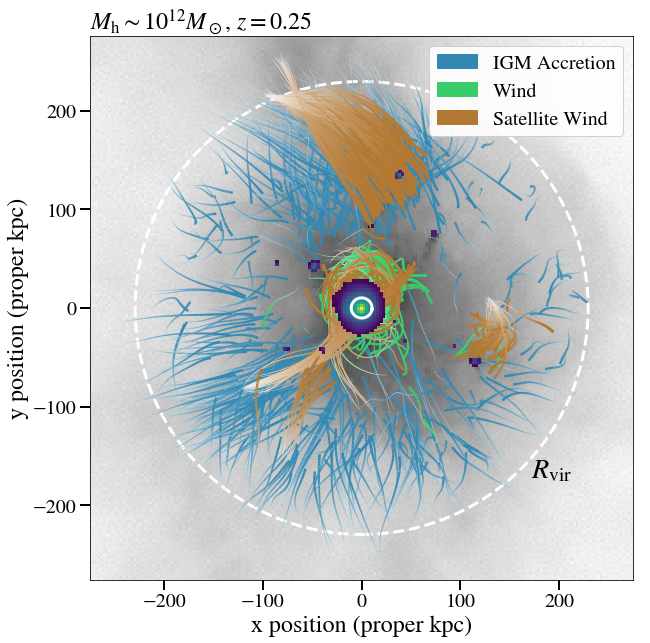

In [37]:
fig = plt.figure( figsize=(10,10), facecolor='white' )
ax = plt.gca()

plotted_range = [ -1.2*r_vir, 1.2*r_vir ]
    
plot_label = r'$M_{ \rm{ h } } \sim 10^{' + config.MASS_BINS[sim_name][1:] + r'} M_\odot$, ' +  r'$z = {:.2g}$'.format( g_data.redshift )
vmaxes = {
    'm10' : 4e3,
    'm11' : 4e3,
    'm12' : 4e3,
}
vmax = vmaxes[config.MASS_BINS[sim_name]]
g_plotter.histogram2d(
    'Rx',
    'Ry',
    cmap = cm.Greys,
    ax = ax,
    x_range = plotted_range,
    y_range = plotted_range,
    n_bins = 200,
#         vmin = 1,
    vmax = vmax,
    add_colorbar = False,
    add_x_label = False,
    add_y_label = False,
    label_fontsize = 24,
    plot_label = plot_label,
)

vmins = {
    172 : {
        'm10' : 10,
        'm11' : 10,
        'm12' : 20,
    },
    214 : {
        'm12' : 50,
    },
    465 : {
        'm10' : 20,
        'm11' : 20,
        'm12' : 5e2,
    },
}
vmin = vmins[snum][config.MASS_BINS[sim_name]]
s_plotter.histogram2d(
    'Rx',
    'Ry',
    cmap = cm.viridis,
    ax = ax,
    x_range = plotted_range,
    y_range = plotted_range,
    n_bins = 200,
    vmin = vmin,
#         vmax = 4e3,
    plot_label = None,
    add_colorbar = False,
    add_x_label = True,
    add_y_label = True,
    x_label = 'x position (proper kpc)',
    y_label = 'y position (proper kpc)',
    label_fontsize = 24,
    zorder = 150,
    min_bin_value_displayed = vmin,
)

# Virial Radius circle
cir = mpatches.Circle(
    [0, 0],
    radius = r_vir,
    linewidth = 3,
    color = 'w',
    linestyle = '--',
    fill = False,
    facecolor = 'w',
)
ax.add_patch( cir )
ax.annotate(
    s = r'$R_{\rm vir}$',
    xy = ( .7475*r_vir, -.7475*r_vir ),
    xycoords = 'data',
    fontsize = 28,
    color = 'k',
    zorder = 150,
)

# Galaxy disk circle
ax.plot(
    rotated_circle[:,0],
    rotated_circle[:,1],
    color = 'w',
    linewidth = 3,
    zorder = 200,
)

# if ax.is_first_col():
#     filter_label = 'No time selection'
# if ax.is_last_col():
#     filter_label = 'Left source {}-{} Gyr ago'.format(
#         t_show_min[snum],
#         t_show_max[snum],
#     )
# ax.annotate(
#     s = filter_label,
#     xy = ( 1., 1. ),
#     xycoords = 'axes fraction',
#     va = 'bottom',
#     ha = 'right',
#     fontsize = 22,
# )

ax.set_aspect( 'equal' )

save_file = 'streamlines_{}_v0.png'.format( defaults['tag'] )
plotting.save_fig(
    out_dir = file_manager.get_project_presentation_dir(),
    save_file = save_file,
    fig = fig,
    resolution = 300,
)

labels = []
color_objects = []
for i, classification in enumerate( [ 'is_CGM_NEP', 'is_outside_any_gal_IP', 'is_outside_any_gal_EP', ] ):

    w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )

    # Don't plot CGM EP for m10s at low-z when applying the time cut, because there are just
    # too few particles
    if (
        classification == 'is_outside_any_gal_EP' and
        ax.is_last_col() and
        config.MASS_BINS[sim_name] == 'm10' and
        snum == 465
    ):
        continue

    print( classification )
    w_plotter.plot_streamlines(
        ax = ax,
        classification = classification,
        classification_ind = ind,
        start_ind = ind,
        sample_size = 500,
        sample_selected_interval = True,
        t_show_min = t_show_min[snum],
        t_show_max = t_show_max[snum],
        x_data_kwargs = data_args[snum],
        y_data_kwargs = data_args[snum],
        linewidth = 2.5,
        plot_halos = False,
        plot_xlabel = False,
        plot_ylabel = False,
        x_range = plotted_range,
        y_range = plotted_range,
        fontsize = 24,
    )

    # Make virtual artists to allow a legend to appear
    color_object = matplotlib.patches.Rectangle(                         
        (0, 0),                                                          
        1,                                                               
        1,                                                               
        fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        alpha = p_constants.CLASSIFICATION_ALPHA,                        
    )                                                                    
    color_objects.append( color_object )                                 
    labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

    leg = ax.legend(
        color_objects,
        labels,
        prop={'size': 20},
        ncol=1,
#         loc=(0.65, 0.83),
        loc='upper right',
        fontsize=24,
        framealpha = 0.9,
    )
    leg.set_zorder( 200 )
    
    save_file = 'streamlines_{}_v{}.png'.format( defaults['tag'], i+1 )
    plotting.save_fig(
        out_dir = file_manager.get_project_presentation_dir(),
        save_file = save_file,
        fig = fig,
        resolution = 300,
    )


is_CGM_NEP
is_outside_any_gal_IP
is_outside_any_gal_EP
File saved at /work/03057/zhafen/presentation_plots/streamlines_m12i_CGM_snum465_galdefv3_v4.png


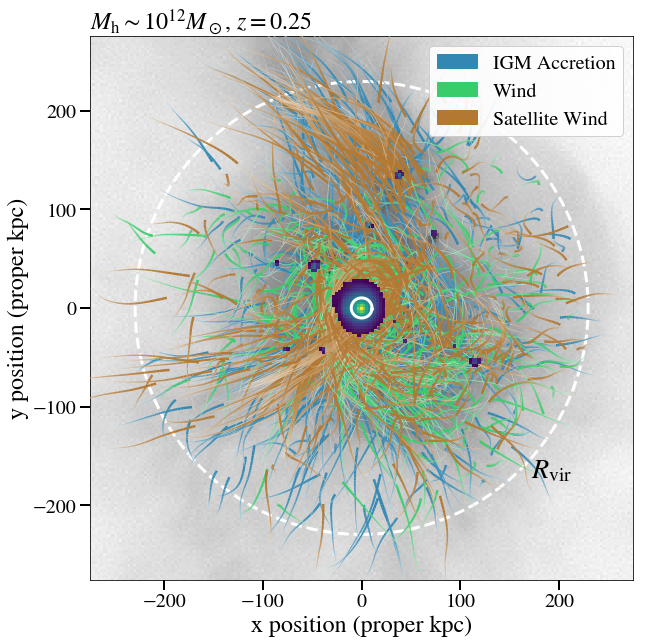

In [38]:
fig = plt.figure( figsize=(10,10), facecolor='white' )
ax = plt.gca()

plotted_range = [ -1.2*r_vir, 1.2*r_vir ]
    
plot_label = r'$M_{ \rm{ h } } \sim 10^{' + config.MASS_BINS[sim_name][1:] + r'} M_\odot$, ' +  r'$z = {:.2g}$'.format( g_data.redshift )
vmaxes = {
    'm10' : 4e3,
    'm11' : 4e3,
    'm12' : 4e3,
}
vmax = vmaxes[config.MASS_BINS[sim_name]]
g_plotter.histogram2d(
    'Rx',
    'Ry',
    cmap = cm.Greys,
    ax = ax,
    x_range = plotted_range,
    y_range = plotted_range,
    n_bins = 200,
#         vmin = 1,
    vmax = vmax,
    add_colorbar = False,
    add_x_label = False,
    add_y_label = False,
    label_fontsize = 24,
    plot_label = plot_label,
)

vmins = {
    172 : {
        'm10' : 10,
        'm11' : 10,
        'm12' : 20,
    },
    214 : {
        'm12' : 50,
    },
    465 : {
        'm10' : 20,
        'm11' : 20,
        'm12' : 5e2,
    },
}
vmin = vmins[snum][config.MASS_BINS[sim_name]]
s_plotter.histogram2d(
    'Rx',
    'Ry',
    cmap = cm.viridis,
    ax = ax,
    x_range = plotted_range,
    y_range = plotted_range,
    n_bins = 200,
    vmin = vmin,
#         vmax = 4e3,
    plot_label = None,
    add_colorbar = False,
    add_x_label = True,
    add_y_label = True,
    x_label = 'x position (proper kpc)',
    y_label = 'y position (proper kpc)',
    label_fontsize = 24,
    zorder = 150,
    min_bin_value_displayed = vmin,
)

# Virial Radius circle
cir = mpatches.Circle(
    [0, 0],
    radius = r_vir,
    linewidth = 3,
    color = 'w',
    linestyle = '--',
    fill = False,
    facecolor = 'w',
)
ax.add_patch( cir )
ax.annotate(
    s = r'$R_{\rm vir}$',
    xy = ( .7475*r_vir, -.7475*r_vir ),
    xycoords = 'data',
    fontsize = 28,
    color = 'k',
    zorder = 150,
)

# Galaxy disk circle
ax.plot(
    rotated_circle[:,0],
    rotated_circle[:,1],
    color = 'w',
    linewidth = 3,
    zorder = 200,
)

# if ax.is_first_col():
#     filter_label = 'No time selection'
# if ax.is_last_col():
#     filter_label = 'Left source {}-{} Gyr ago'.format(
#         t_show_min[snum],
#         t_show_max[snum],
#     )
# ax.annotate(
#     s = filter_label,
#     xy = ( 1., 1. ),
#     xycoords = 'axes fraction',
#     va = 'bottom',
#     ha = 'right',
#     fontsize = 22,
# )

ax.set_aspect( 'equal' )

labels = []
color_objects = []
for i, classification in enumerate( [ 'is_CGM_NEP', 'is_outside_any_gal_IP', 'is_outside_any_gal_EP', ] ):

    w_plotter.data_object.data_masker.mask_data( 'PType', data_value=config.PTYPE_GAS )

    # Don't plot CGM EP for m10s at low-z when applying the time cut, because there are just
    # too few particles
    if (
        classification == 'is_outside_any_gal_EP' and
        ax.is_last_col() and
        config.MASS_BINS[sim_name] == 'm10' and
        snum == 465
    ):
        continue

    print( classification )
    w_plotter.plot_streamlines(
        ax = ax,
        classification = classification,
        classification_ind = ind,
        start_ind = ind,
        sample_size = 500,
        sample_selected_interval = False,
        t_show_min = t_show_min[snum],
        t_show_max = t_show_max[snum],
        x_data_kwargs = data_args[snum],
        y_data_kwargs = data_args[snum],
        linewidth = 2.5,
        plot_halos = False,
        plot_xlabel = False,
        plot_ylabel = False,
        x_range = plotted_range,
        y_range = plotted_range,
        fontsize = 24,
    )

    # Make virtual artists to allow a legend to appear
    color_object = matplotlib.patches.Rectangle(                         
        (0, 0),                                                          
        1,                                                               
        1,                                                               
        fc = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        ec = p_constants.CLASSIFICATION_COLORS_B[classification],                                 
        alpha = p_constants.CLASSIFICATION_ALPHA,                        
    )                                                                    
    color_objects.append( color_object )                                 
    labels.append( p_constants.CLASSIFICATION_LABELS[classification] )

    leg = ax.legend(
        color_objects,
        labels,
        prop={'size': 20},
        ncol=1,
#         loc=(0.65, 0.83),
        loc='upper right',
        fontsize=24,
        framealpha = 0.9,
    )
    leg.set_zorder( 200 )
    
save_file = 'streamlines_{}_v{}.png'.format( defaults['tag'], 4 )
plotting.save_fig(
    out_dir = file_manager.get_project_presentation_dir(),
    save_file = save_file,
    fig = fig,
    resolution = 300,
)
